In [97]:
from sklearn import datasets
import os
import numpy as np
import cv2 # OpenCV
from sklearn.svm import SVC # SVM klasifikator
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier # KNN
import matplotlib.pyplot as plt
%matplotlib inline

In [98]:
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

def display_image(image):
    plt.figure()
    plt.imshow(image)

### HOG

In [99]:
def get_hog():
    img_size = (90, 90)
    nbins = 9
    cell_size = (8, 8)
    block_size = (3, 3)
    hog = cv2.HOGDescriptor(_winSize=(img_size[1] // cell_size[1] * cell_size[1],
                                      img_size[0] // cell_size[0] * cell_size[0]),
                            _blockSize=(block_size[1] * cell_size[1],
                                        block_size[0] * cell_size[0]),
                            _blockStride=(cell_size[1], cell_size[0]),
                            _cellSize=(cell_size[1], cell_size[0]),
                            _nbins=nbins)
    return hog

In [100]:
def get_features_and_labels(hog, train_dir):
    features=[]
    labels = []
    for i in range(100):
        if i%100==0:
            print(i)
        for img_name in os.listdir(train_dir):
            img_path = os.path.join(train_dir, img_name)
            img = load_image(img_path)
            features.append(hog.compute(img))
            if img_name[0]=='b':
                labels.append(img_name[2])
            elif img_name[0]=='w':
                labels.append(img_name[2].upper())
            elif img_name[0]=='e':
                labels.append(img_name[0])
        
    return np.array(features), np.array(labels)
    
    

In [101]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

def train_classifier(x_train, y_train):
    
    print("Treniranje klasifikatora...")
    classifier = SVC(kernel='linear', probability=True)
    classifier.fit(x_train, y_train)
    
    return classifier

In [102]:
train_dir='../data/pictures/'

hog = get_hog()
x_train, y_train = get_features_and_labels(hog, train_dir)

classifier = train_classifier(x_train, y_train)


0


Treniranje klasifikatora...


### HOUGH

In [103]:
def detect_lines(gray_img):
    
    edges_img = cv2.Canny(gray_img, 50, 150, apertureSize=3)
    min_line_length = 300
    lines = cv2.HoughLinesP(image=edges_img, rho=1, theta=np.pi/180, threshold=10, lines=np.array([]),
                            minLineLength=min_line_length, maxLineGap=30)

    lines[:, :, 1]=gray_img.shape[0] - lines[:, :, 1]
    lines[:, :, 3]=gray_img.shape[0] - lines[:, :, 3]

    
    lines = np.vstack([lines, [
        [[0, 1, 719, 1]],
        [[0, 721, 719, 721]],
        [[-1, 1, -1, 720]],
        [[719, 1, 719, 720]]
    ]])
    return lines
    

In [111]:
def check_fields_similarity(frame_field, next_frame_field, classifier, hog, p=False):
    
    frame_field=cv2.resize(frame_field, (90,90),interpolation=cv2.INTER_NEAREST)
    next_frame_field=cv2.resize(next_frame_field, (90,90),interpolation=cv2.INTER_NEAREST)
    f1=classifier.predict(hog.compute(frame_field).reshape(1, -1))
    f2=classifier.predict(hog.compute(next_frame_field).reshape(1, -1))
    ff1=classifier.predict_proba(hog.compute(frame_field).reshape(1, -1))
    ff2=classifier.predict_proba(hog.compute(next_frame_field).reshape(1, -1))
    ind1=np.argmax(ff1)
    ind2=np.argmax(ff2)
    # if(p):
    #     print(classifier.classes_)
    #     plt.figure()
    #     plt.imshow(frame_field)
    #     plt.figure()
    #     plt.imshow(next_frame_field)
    #     plt.figure()
    #     plt.imshow(load_image('../data/pictures/b_p2.png'))
    #     train_img=load_image('../data/pictures/b_p2.png')
    #     ff1=classifier.predict_proba(hog.compute(frame_field).reshape(1, -1))
    #     ff2=classifier.predict_proba(hog.compute(next_frame_field).reshape(1, -1))
    #     ff3=classifier.predict_proba(hog.compute(load_image('../data/pictures/b_p2.png')).reshape(1, -1))
    #     print(f1, f2)
    #     print(ff1,'\n',ff2, '\n', ff3)
        
    return (classifier.classes_[ind1], classifier.classes_[ind2])
    return (f1[0], f2[0])
    

### operacije

In [105]:
def invert(similarities):
    inverse=[]
    for i in range (8):
        for j in range(8):
            inverse.append(similarities[j*8+i])
    return inverse

In [106]:
def change_fem_row(row, idx, char):
    full_row=''
    for c in row:
        if '9'>c>'0':
            full_row+='e'*int(c)
        else:
            full_row+=c
    full_row=full_row[:idx]+char+full_row[idx+1:]
    row=''
    cons_e=0
    for c in full_row:
        if c!='e':
            if cons_e!=0:
                row+=str(cons_e)
                cons_e=0
            row+=c
        else:
            cons_e+=1
    if cons_e!=0:
        row+=str(cons_e)
    return row

In [107]:
def get_fem_format(fem, figure, start_iter, end_iter):
    # rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w
    fem_table=fem[:-2]
    next_move=chr(217-ord(fem[-1]))
    rows=fem_table.split('/')
    if figure in ['k','K'] and abs(start_iter//8-end_iter//8)>1:
        #king
        rows[start_iter%8]=change_fem_row(rows[start_iter%8], start_iter//8, 'e')
        rows[end_iter%8]=change_fem_row(rows[end_iter%8], end_iter//8, figure)
        #rook
        rows[start_iter%8]=change_fem_row(rows[start_iter%8], 0 if end_iter<start_iter else 7, 'e')
        rows[end_iter%8]=change_fem_row(rows[end_iter%8], end_iter//8+1 if end_iter<start_iter else end_iter//8-1, 'r' if figure=='k' else 'R' )
    else: 
        rows[start_iter%8]=change_fem_row(rows[start_iter%8], start_iter//8, 'e')
        rows[end_iter%8]=change_fem_row(rows[end_iter%8], end_iter//8, figure)
    new_fem=''
    for i in range(8):
        new_fem+=rows[i]
        if i!=7:
            new_fem+='/'
    new_fem+=' '+next_move
    return new_fem

### main

In [108]:
def detect_moves(video_path,start_pos,lines,classifier,hog):
    cap = cv2.VideoCapture(video_path)
    cap.set(1,0)
    next_frame=start_pos
    # lines.append()
    moves=[]
    frames=0
    moves_count=2
    fem="rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w"
    castling='KQkq'
    while True:
        frame=next_frame
        grabbed, next_frame= cap.read()
        
        if not grabbed:
            break
        next_frame=cv2.cvtColor(next_frame, cv2.COLOR_BGR2RGB)

        frames+=1
        # if frames==17:
        #     plt.figure()
        #     plt.imshow(frame)
        #     plt.figure()
        #     plt.imshow(next_frame)

        half_size=int(len(lines)/2)
        iter=0

        similarities=[]
        differences=[]
        for vert_line_ind in range(half_size-1):
            for hor_line_ind in range(half_size-1):
                x1=lines[half_size+hor_line_ind][0][0]+1
                x2=lines[half_size+hor_line_ind+1][0][0]+1
                y1=lines[vert_line_ind][0][1]-1
                y2=lines[vert_line_ind+1][0][1]-1
                # if frames==8 and 2<vert_line_ind<4 and 3<hor_line_ind<5:
                #     f1, f2=check_fields_similarity(frame[x1:x2, y1:y2],next_frame[x1:x2, y1:y2], classifier, hog, True)
                
                f1, f2=check_fields_similarity(frame[x1:x2, y1:y2],next_frame[x1:x2, y1:y2], classifier, hog)
                similarities.append(f1==f2)
                if f1!=f2:
                    # if frames==8:
                    #     print(f1, f2, frames,'\n')
                    differences.append((f1,f2, iter))
                    
                iter+=1
        if len(differences)==2:
            if differences[0][1]=='e':
                figure=differences[0][0]
                start_iter=differences[0][2]
                start_field=chr(ord('a') + differences[0][2]//8) +''+str(8-differences[0][2]%8)
                end_iter=differences[1][2]
                end_field=chr(ord('a') + differences[1][2]//8) +''+str(8-differences[1][2]%8)
            elif differences[1][1]=='e':
                figure=differences[1][0]
                start_iter=differences[1][2]
                start_field=chr(ord('a') + differences[1][2]//8) +''+str(8-differences[1][2]%8)
                end_iter=differences[0][2]
                end_field=chr(ord('a') + differences[0][2]//8) +''+str(8-differences[0][2]%8)
        
        if len(differences)==4:
            for i in range(4):
                if differences[i][0] in ['k','K'] and differences[i][1]=='e':
                    figure=differences[i][0]
                    start_iter=differences[i][2]
                    start_field=chr(ord('a') + differences[i][2]//8) +''+str(8-differences[i][2]%8)
                elif differences[i][0]=='e' and differences[i][1] in ['k','K']:
                    end_iter=differences[i][2]
                    end_field=chr(ord('a') + differences[i][2]//8) +''+str(8-differences[i][2]%8)
            
            if start_iter%8==0 and end_iter%8==0:
                if abs(start_iter//8-end_iter//8)==2:
                    castling=castling[:2]+'-'+castling[3:]
                elif abs(start_iter//8-end_iter//8)==3:
                    castling=castling[:3]+'-'
            else:
                if abs(start_iter//8-end_iter//8)==2:
                    castling='-'+castling[1:]
                elif abs(start_iter//8-end_iter//8)==3:
                    castling=castling[:1]+'-'+castling[2:]

        if 0<len(differences)<5:
            similarities=invert(similarities)
            fem=get_fem_format(fem, figure, start_iter, end_iter)
            moves.append((start_field+end_field, fem+' '+castling+' - 0 '+str(moves_count//2)))
            moves_count+=1
        

    return moves

        

18
board (1).gif
p e 8 

['B' 'K' 'N' 'P' 'Q' 'R' 'b' 'e' 'k' 'n' 'p' 'q' 'r']
['P'] ['p']
[[0.00557962 0.00352544 0.00536294 0.91541953 0.00339167 0.00513518
  0.00407766 0.00566553 0.00258172 0.00366241 0.03928594 0.00280004
  0.00351233]] 
 [[0.00687237 0.00471945 0.00669916 0.0210402  0.00433133 0.00665426
  0.00649676 0.00656355 0.00493832 0.00657992 0.91361354 0.00524986
  0.00624128]] 
 [[0.00232114 0.00130727 0.0015992  0.00545773 0.00109975 0.00198331
  0.00312884 0.00318205 0.00173409 0.00180006 0.97268856 0.00136633
  0.00233166]]
P p 8 



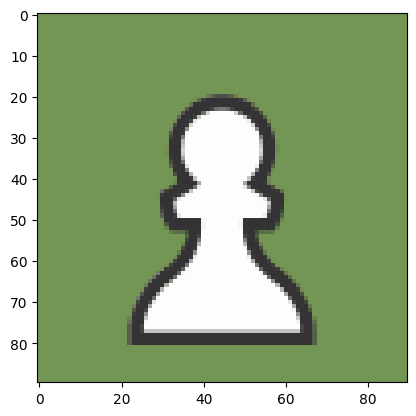

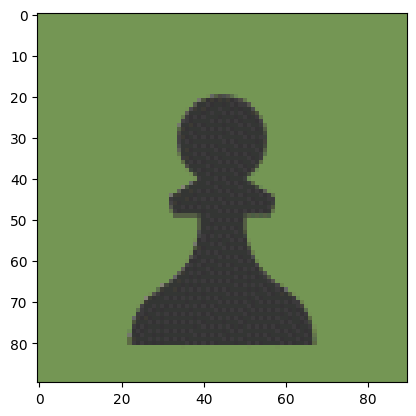

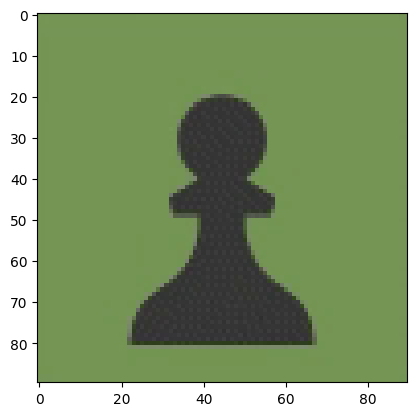

In [112]:
start_pos_img=load_image('../data/start1.png')

output_file_path='../data/moves.txt'
lines=detect_lines(start_pos_img)
lines = sorted(lines, key=lambda line: (line[0][0], line[0][1]))
first_line = lines.pop(0)

lines.insert(9, first_line)


video_dir='../data/videos/'
with open(output_file_path, 'w'):
    pass
with open(output_file_path, 'a') as file:
        for video in os.listdir(video_dir):
        
            print(video)
            video_path = os.path.join(video_dir, video)
            moves=detect_moves(video_path,start_pos_img, lines, classifier, hog)
            for move in moves:
                    file.write(f"{move[0]}, {move[1]}\n")
